# Initialize

In [1]:
import torch
from sbi.inference import SNPE, simulate_for_sbi
from sbi.utils import BoxUniform
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
from sbi.analysis import pairplot
# from simulator import modified_TM, modified_TM_x_z, modified_TM_x_z_ind, mean_function,from_means

/gpfs/soma_fs/scratch/saka/anaconda_isf3/envs/sbi_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from mining_silver.simulator_diffusion import  profile_from_theta_single, diffusion_from_theta_single
from mining_silver.simulator_diffusion import diffusion_from_theta_with_latent_single, measurement_from_profile_single
import matplotlib.pyplot as plt

In [4]:
from mining_silver.utils import simulate_two_step, two_step_sampling_from_obs

In [5]:
from functools import partial
import time 

In [6]:
def train_inferer(prior_samples, sims):
    inference = SNPE(density_estimator='nsf')
    inference = inference.append_simulations(prior_samples, sims)
    density_estimator = inference.train()
    posterior = inference.build_posterior(density_estimator)
    return density_estimator, posterior

def sample_from_obs(posterior, obs, n_post_samples=1000000):
    ''' common default values are theta_posterior, x_o'''
    posterior.set_default_x(obs)
    post_samples = posterior.sample((n_post_samples,), show_progress_bars=False)
    return post_samples

In [7]:
# just make different simulations. if you use the same pool, you are probably taking some of the same 

In [8]:
simulate_fun = partial(simulate_two_step, latent_variables_simulator = profile_from_theta_single, 
                        from_latent_simulator = measurement_from_profile_single)

In [9]:
def infer_diffusion_two_step(x_o, num_simul, simulate_fun): 
    t1 = time.time()
    prior = BoxUniform(low=torch.tensor([0.0,0.0]), high=torch.tensor([5.0 , 6.0]))
    theta, z_sim, x_sim = simulate_fun(theta_prior = prior, num_simul = num_simul)
    
    Z_density_estimator, Z_posterior = train_inferer(z_sim, x_sim)

    zx_sim = torch.concatenate([z_sim, x_sim], dim=1)
    theta_density_estimator, theta_posterior = train_inferer(theta, zx_sim)

    t2 = time.time()
    t_tot = t2 - t1 
    out = {}
    
    out['z_posterior'] = Z_posterior
    out['z_density_estimator'] = Z_density_estimator

    out['theta_posterior_from_zx'] = theta_posterior 
    out['theta_density_estimator_from_zx'] = theta_density_estimator
    out['time'] = t_tot
    
    return out #theta_post_samples 

In [11]:
def infer_diffusion_one_step(x_o, num_simul, simulate_fun): 
    t1 = time.time()
    prior = BoxUniform(low=torch.tensor([0.0,0.0]), high=torch.tensor([5.0 , 6.0]))
    theta, z_sim, x_sim = simulate_fun(theta_prior = prior, num_simul = num_simul)
    density_estimator, theta_posterior = train_inferer(theta, x_sim)
    t2 = time.time()
    t_tot = t2 - t1 

    out = {}
    
    out['posterior'] = theta_posterior
    out['density_estimator'] = density_estimator
    out['time'] = t_tot

    return out #post_samples

## Test 

In [78]:
# get theta_o and x_o for looking at the prior 
prior = BoxUniform(low=torch.tensor([0.0,0.0]), high=torch.tensor([5.0 , 6.0]))
prior, num_parameters, prior_returns_numpy = process_prior(prior)
theta_o = prior.sample((1,))
x_o = diffusion_from_theta_single(theta_o)

In [95]:
%matplotlib inline
# run two step for 1000 sims 
out = infer_diffusion_two_step(x_o, 1000, simulate_fun = simulate_fun)

In [139]:
# grab the posteriors and grab samples to plot
theta_posterior, Z_posterior =  out['theta_posterior_from_zx'], out['z_posterior']
Z_posterior_samples, theta_posterior_samples = two_step_sampling_from_obs(Z_posterior, theta_posterior, 
                                                                          x_o, 100, 1000)

/gpfs/soma_fs/scratch/saka/anaconda_isf3/envs/sbi_env5/lib/python3.9/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2184.)
  outputs, _ = torch.triangular_solve(


In [151]:
plot?

(<Figure size 1000x1000 with 4 Axes>,
 array([[<Axes: xlabel='dim 1'>, <Axes: >],
        [<Axes: >, <Axes: xlabel='dim 2'>]], dtype=object))

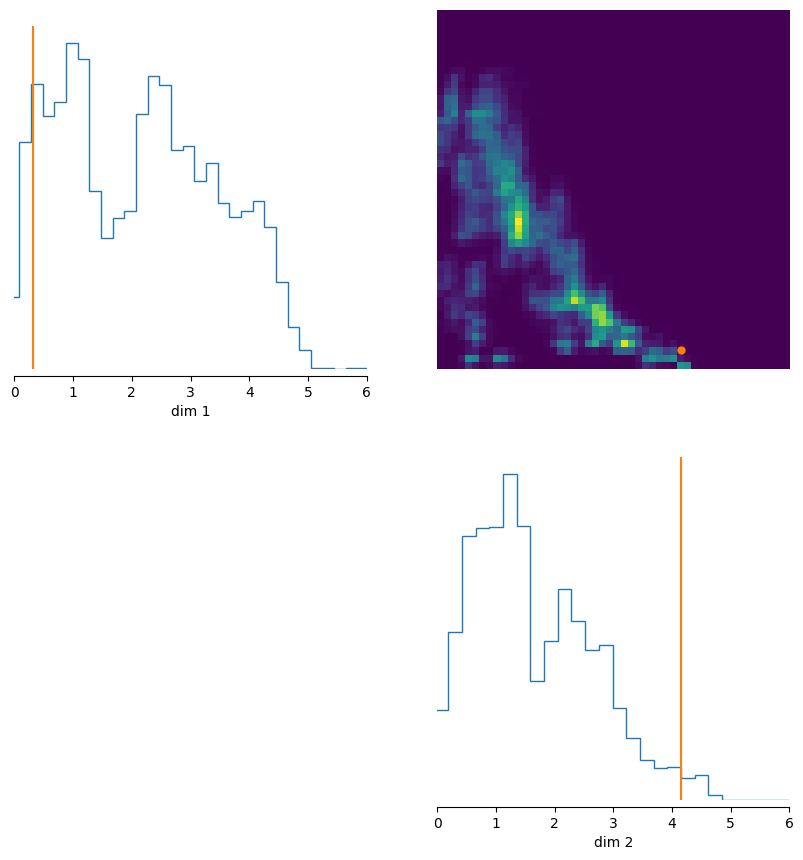

In [148]:
pairplot(theta_posterior_samples, limits =[[0,6], [0,6]], points = theta_o)

# Parallelize

In [15]:
import dask 
import os
import pickle

In [16]:
NUM_SIM_FULL = [100, 200, 300, 500, 1000, 2000, 3000, 5000, 10000, 20000, 100000]

In [17]:
NUM_SIM_LARGE = [10000, 20000]

In [18]:
rep_per_sim_num = {name: 8 for name in NUM_SIM_FULL if name not in NUM_SIM_LARGE }
rep_per_sim_num.update({name: 3 for name in NUM_SIM_LARGE})
rep_per_sim_num[100000] = 1 

In [19]:
@dask.delayed 
def run_and_save(name, inference_fun, simulate_fun, outdir, x_o, n_sim, n_rep): 
    out = inference_fun(x_o, n_sim, simulate_fun)
    path = os.path.join(outdir, '_'.join([name, f'n_sim_{n_sim}', f'{n_rep}th_rep'])) 
    with open(path, 'wb') as f: 
        pickle.dump(out, file = f)

In [20]:
outdir = '/gpfs/soma_fs/scratch/saka/notebooks/project3/results_v1'

In [21]:
names = ['one_step', 'two_steps']
infer_funs = [infer_diffusion_one_step, infer_diffusion_two_step]

delayeds = []
for n_sim in NUM_SIM_FULL: 
    for n_rep in range(rep_per_sim_num[n_sim]):
        for name, inference_fun in zip(names, infer_funs):
            delayeds.append(run_and_save(name, inference_fun, simulate_fun, outdir, x_o, n_sim, n_rep))

In [22]:
# os.mkdir('/gpfs/soma_fs/scratch/saka/notebooks/project3/slurm_v1')

In [23]:
## init
dask2slrm_TEMPLATE = '''#!/bin/bash

# Example of running python script with a job array

#SBATCH -J dsk2slrm
#SBATCH -p CPU,GPU
#SBATCH --array=1-{}                    # how many tasks in the array
#SBATCH -c 1                            # one CPU core per task
#SBATCH -t 24:00:00
#SBATCH -o run-%j-%a.out
#SBATCH -e run-%j-%a.err
#SBATCH --mem=8000


# Run python script with a command line argument
srun {} run.py $SLURM_ARRAY_TASK_ID 
'''

runpy_TEMPLATE = '''import os
import sys
import cloudpickle
import dask
path = '{}'
n_folders = {}
id_ = int(sys.argv[1])
basedir = os.path.basename(path)
subdir = str((id_ - 1) % n_folders)
path_to_delayed = os.path.join(path, subdir, str(id_))
if os.path.exists(path_to_delayed + '.done'):
    exit()
with open(path_to_delayed, 'rb') as f:
    d = cloudpickle.load(f)
dask.compute(d, scheduler = 'synchronous')
os.rename(path_to_delayed, path_to_delayed+'.done')'''

import numpy as np
import os
import sys
import cloudpickle

def convertible_to_int(x):
        try:
            int(x)
            return True
        except:
            return False
        
def save_delayeds_in_folder(folder_, ds, files_per_folder = 10):
    n_folders = int(np.ceil(len(ds) / files_per_folder))
    for lv, d in enumerate(ds):
        subdir = str(lv % n_folders)
        if not os.path.exists(os.path.join(folder_,subdir)):
            os.makedirs(os.path.join(folder_,subdir))
        with open(os.path.join(folder_,subdir,str(lv+1)), 'wb') as f:
            cloudpickle.dump(d, f)
    with open(os.path.join(folder_,'slurm.sh'), 'w') as f:
        f.write(dask2slrm_TEMPLATE.format(len(ds)+1, sys.executable))
    with open(os.path.join(folder_,'run.py'), 'w') as f:
        f.write(runpy_TEMPLATE.format(folder_, n_folders))
        
def check_all_done(folder_):
    subdirs =  [f for f in os.listdir(folder_) if convertible_to_int(f)]
    for s in subdirs:
        full_path = os.path.join(folder_, s)
        ds = os.listdir(full_path)
        for d in ds:
            if not d.endswith('.done'):
                print(s,d)

In [188]:
os.mkdir('/gpfs/soma_fs/scratch/saka/notebooks/project3/slurm_v4')

In [189]:
slurmdir = '/gpfs/soma_fs/scratch/saka/notebooks/project3/slurm_v4'

In [190]:
save_delayeds_in_folder(slurmdir, delayeds)

# Load the results

In [27]:
outdir

'/gpfs/soma_fs/scratch/saka/notebooks/project3/results_v1'

In [24]:
name = 'one_step'
results_one_step = {}
for n_sim in NUM_SIM_FULL: 
    out_list = []
    for n_rep in range(rep_per_sim_num[n_sim]):
        if n_sim == 100000: 
            n_rep = 1
        path = os.path.join(outdir, '_'.join([name, f'n_sim_{n_sim}', f'{n_rep}th_rep'])) 
        with open(path, 'rb') as f: 
            out = pickle.load(file = f)
        out_list.append(out)
    results_one_step[str(n_sim)] = out_list

In [25]:
name = 'two_steps'
results_two_step = {}
for n_sim in NUM_SIM_FULL: 
    out_list = []
    for n_rep in range(rep_per_sim_num[n_sim]):
        if n_sim == 100000: 
            n_rep = 1
        path = os.path.join(outdir, '_'.join([name, f'n_sim_{n_sim}', f'{n_rep}th_rep'])) 
        with open(path, 'rb') as f: 
            out = pickle.load(file = f)
        out_list.append(out)
    results_two_step[str(n_sim)] = out_list

In [26]:
results_dict = {}
results_dict['one_step'] = results_one_step
results_dict['two_steps'] = results_two_step

# Calculate Distances 

In [79]:
from sbi.utils.metrics import c2st
from mining_silver.utils import sliced_wasserstein_distance

In [80]:
def get_samples(out, x_o): 
    if 'z_posterior' in out.keys(): 
        theta_posterior, Z_posterior =  out['theta_posterior_from_zx'], out['z_posterior']
        return two_step_sampling_from_obs(Z_posterior, theta_posterior, x_o, 1000, 100)[0]
    else: 
        theta_posterior = out['posterior']
        return sample_from_obs(theta_posterior, x_o)

In [81]:
ground_truth = get_samples(results_two_step['100000'][0], x_o)[:1000,:]

In [82]:
one_step_ground_truth = get_samples(results_one_step['100000'][0], x_o)[:1000,:]

In [87]:
c2st_std_to_ground = {}
wass_std_to_ground = {}

c2st_twostep_to_ground = {}
wass_twostep_to_ground = {}

for n_sim, list_ in results_one_step.items(): 
    c2st_std_to_ground[n_sim] = []
    wass_std_to_ground[n_sim] = []
    for i, out in enumerate(list_): 
        samples = get_samples(out, x_o)[:1000,:]
        c2st_std_to_ground[n_sim].append(c2st(samples, ground_truth))
        wass_std_to_ground[n_sim].append(sliced_wasserstein_distance(samples, ground_truth))

for n_sim, list_ in results_two_step.items(): 
    print(n_sim)
    c2st_twostep_to_ground[n_sim] = []
    wass_twostep_to_ground[n_sim] = []
    for out in list_: 
        samples = get_samples(out, x_o)[:1000,:]
        c2st_twostep_to_ground[n_sim].append(c2st(samples, ground_truth))
        wass_twostep_to_ground[n_sim].append(sliced_wasserstein_distance(samples, ground_truth))      

100
200
300
500
1000
2000
3000
5000
10000
20000
100000


### Parallelize 

In [83]:
@dask.delayed
def compute_distances(name, n_sim, n_rep, out, x_o, outdir, ground_truth): 
    samples = get_samples(out, x_o)[:1000,:]
    out = []
    out.append(c2st(samples, ground_truth))
    out.append(sliced_wasserstein_distance(samples, ground_truth))
    
    path = os.path.join(outdir, '_'.join([name, f'n_sim_{n_sim}', f'{n_rep}th_rep'])) 
    with open(path, 'wb') as f: 
        pickle.dump(out, file = f)

In [94]:
outdir_dist = '/gpfs/soma_fs/scratch/saka/notebooks/project3/results_dist_different_x_o'

In [95]:
#get delayeds for ground truth from one step 
delayeds = []
for name in names: 
    for n_sim, list_ in results_dict[name].items():
        for i, out in enumerate(list_): 
            delayeds.append(compute_distances(name + '_one_step_ground', n_sim, n_rep = i, out = out, x_o = x_o, 
                                              outdir = outdir_dist, ground_truth = one_step_ground_truth))

In [96]:
len(delayeds)

142

In [97]:
os.mkdir('/gpfs/soma_fs/scratch/saka/notebooks/project3/slurm_v7')

In [98]:
slurmdir = '/gpfs/soma_fs/scratch/saka/notebooks/project3/slurm_v7'

In [99]:
save_delayeds_in_folder(slurmdir, delayeds)

In [100]:
#load the dists 
distances_one_step_ground = {}

for name in names: 
    distances_one_step_ground[name] = {}
    for n_sim, list_ in results_dict[name].items():
        distances_one_step_ground[name][n_sim] = []
        for i in range(len(list_)): 
            n_rep = i
            path = os.path.join(outdir_dist, '_'.join([name + '_one_step_ground', f'n_sim_{n_sim}', f'{n_rep}th_rep'])) 
            with open(path, 'rb') as f: 
                out = pickle.load(file = f)
            distances_one_step_ground[name][n_sim].append(out)

# Figures

## Distances figure

In [82]:
c2st_std_to_ground.keys()

dict_keys(['100', '200', '300', '500', '1000', '2000', '3000', '5000', '10000', '20000', '100000'])

In [ ]:
c2st_std  = [np.mean(c2st_std_to_ground[str(n_sim)]) for n_sim in NUM_SIM_FULL]
c2st_twostep =[np.mean(c2st_twostep_to_ground[str(n_sim)]) for n_sim in NUM_SIM_FULL]
wass_std = [np.mean(wass_std_to_ground[str(n_sim)]) for n_sim in NUM_SIM_FULL]
wass_twostep =[np.mean(wass_twostep_to_ground[str(n_sim)]) for n_sim in NUM_SIM_FULL]

In [92]:
print([np.mean(c2st_std_to_ground[str(n_sim)]) for n_sim in NUM_SIM_FULL])
print([np.mean(c2st_twostep_to_ground[str(n_sim)]) for n_sim in NUM_SIM_FULL])
print([np.mean(wass_std_to_ground[str(n_sim)]) for n_sim in NUM_SIM_FULL])
print([np.mean(wass_twostep_to_ground[str(n_sim)]) for n_sim in NUM_SIM_FULL])

[0.958, 0.96675, 0.9778125, 0.982625, 0.98356247, 0.98443747, 0.984375, 0.9818125, 0.9816666, 0.9871667, 0.9855]
[0.8919375, 0.70406246, 0.631125, 0.56543756, 0.5355, 0.52831244, 0.5193125, 0.52806246, 0.513, 0.51783335, 0.4975]
[1.4226704, 1.3575764, 1.2810743, 1.0600351, 0.9844383, 1.010479, 1.0244893, 1.0433631, 1.0151948, 1.0764085, 1.0186824]
[0.61645514, 0.2424409, 0.14887533, 0.039326094, 0.020691467, 0.016300792, 0.0058612535, 0.010669662, 0.006330621, 0.000991554, 0.0035559973]


In [101]:
# now for the ground truth from one_step 
c2st_std_ogt = [np.mean([item[0] for item in distances_one_step_ground['one_step'][str(n_sim)]]) 
             for n_sim in NUM_SIM_FULL]
c2st_twostep_ogt = [np.mean([item[0] for item in distances_one_step_ground['two_steps'][str(n_sim)]]) 
             for n_sim in NUM_SIM_FULL]
wass_std_ogt = [np.mean([item[1] for item in distances_one_step_ground['one_step'][str(n_sim)]]) 
             for n_sim in NUM_SIM_FULL]
wass_twostep_ogt = [np.mean([item[1] for item in distances_one_step_ground['two_steps'][str(n_sim)]]) 
             for n_sim in NUM_SIM_FULL]

Text(0, 0.5, 'Sliced Wasserstein distance')

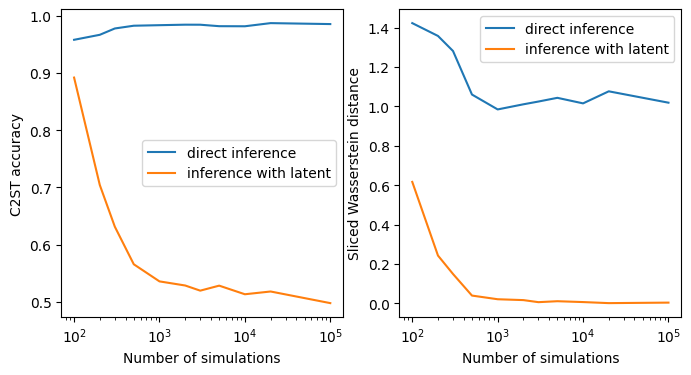

In [107]:
fig, ax = plt.subplots(1, 2, figsize = (8, 4))

ax[0].semilogx(NUM_SIM_FULL, c2st_std, label = 'direct inference')
ax[0].semilogx(NUM_SIM_FULL, c2st_twostep, label = 'inference with latent')
ax[1].semilogx(NUM_SIM_FULL, wass_std, label = 'direct inference')
ax[1].semilogx(NUM_SIM_FULL, wass_twostep, label = 'inference with latent')
ax[0].legend()
ax[1].legend()


ax[0].set_xlabel('Number of simulations')
ax[1].set_xlabel('Number of simulations')

ax[0].set_ylabel('C2ST accuracy')
ax[1].set_ylabel('Sliced Wasserstein distance')

Text(0, 0.5, 'Wasserstein distance')

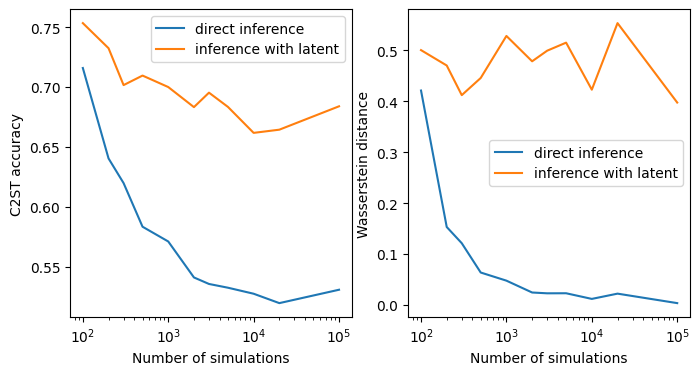

In [106]:
fig, ax = plt.subplots(1, 2, figsize = (8, 4))

ax[0].semilogx(NUM_SIM_FULL, c2st_std_ogt, label = 'direct inference')
ax[0].semilogx(NUM_SIM_FULL, c2st_twostep_ogt, label = 'inference with latent')
ax[1].semilogx(NUM_SIM_FULL, wass_std_ogt, label = 'direct inference')
ax[1].semilogx(NUM_SIM_FULL, wass_twostep_ogt, label = 'inference with latent')
ax[0].legend()
ax[1].legend()


ax[0].set_xlabel('Number of simulations')
ax[1].set_xlabel('Number of simulations')

ax[0].set_ylabel('C2ST accuracy')
ax[1].set_ylabel('Wasserstein distance')

Text(0, 0.5, 'Wasserstein distance')

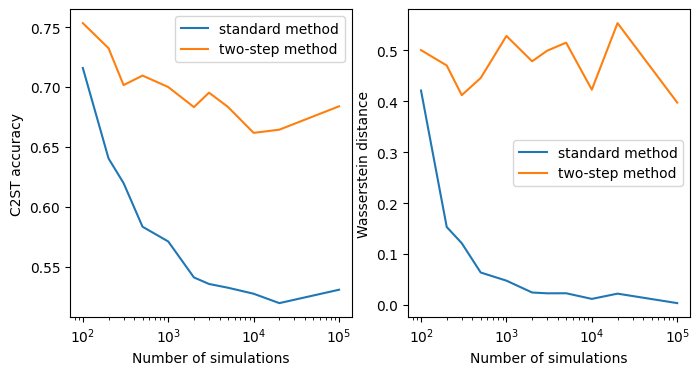

In [102]:
fig, ax = plt.subplots(1, 2, figsize = (8, 4))

ax[0].semilogx(NUM_SIM_FULL, c2st_std_ogt, label = 'standard method')
ax[0].semilogx(NUM_SIM_FULL, c2st_twostep_ogt, label = 'two-step method')
ax[1].semilogx(NUM_SIM_FULL, wass_std_ogt, label = 'standard method')
ax[1].semilogx(NUM_SIM_FULL, wass_twostep_ogt, label = 'two-step method')
ax[0].legend()
ax[1].legend()


ax[0].set_xlabel('Number of simulations')
ax[1].set_xlabel('Number of simulations')

ax[0].set_ylabel('C2ST accuracy')
ax[1].set_ylabel('Sliced Wasserstein distance')

## Posteriors Figure 

In [167]:
# nope too much work
# fig, axes = plt.subplots(2,10, figsize = (30, 4))

(<Figure size 1000x1000 with 4 Axes>,
 array([[<Axes: xlabel='dim 1'>, <Axes: >],
        [<Axes: >, <Axes: xlabel='dim 2'>]], dtype=object))

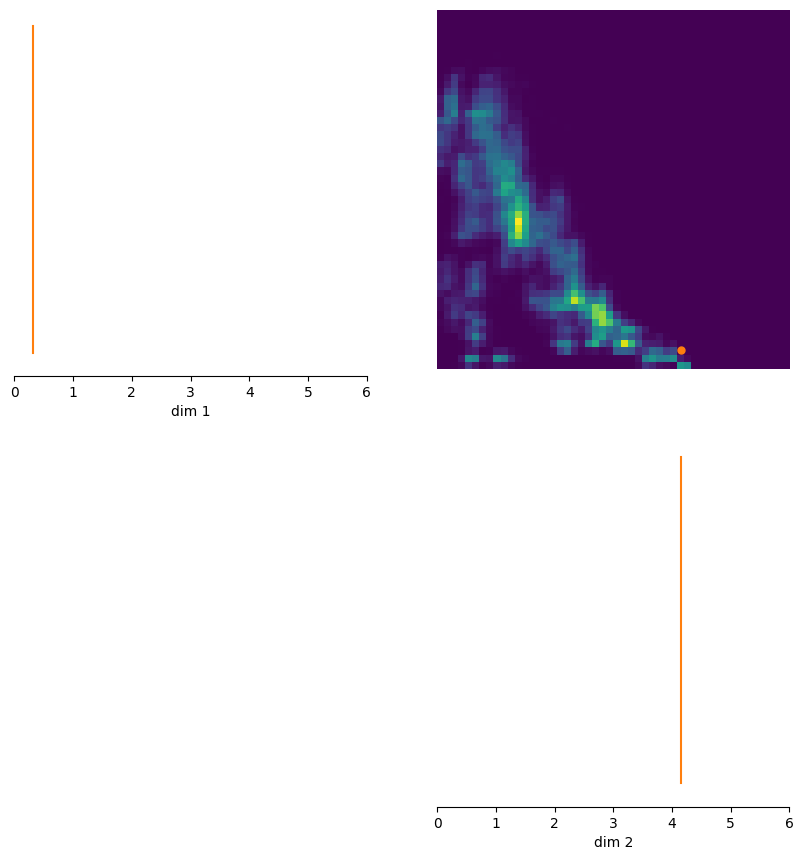

In [168]:
pairplot(theta_posterior_samples, limits =[[0,6], [0,6]], points = theta_o , diag = None)

## Time figure 

In [38]:
times = {}
for name in names: 
    times[name] = {}
    for n_sim, list_ in results_dict[name].items(): 
        times[name][n_sim] = [out['time'] for out in list_]

In [43]:
without_100000 = list(times[name].keys())[:-1]

Text(0, 0.5, 'Time (s)')

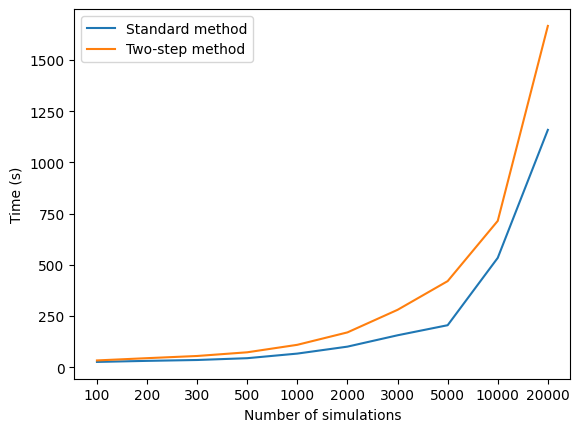

In [55]:
plt.figure()
labels = ['Standard method', 'Two-step method']
for name, label in zip(names, labels): 
    plt.plot(without_100000, [np.mean(times[name][n_sim]) for n_sim in without_100000], label = label)

    ax = plt.gca()
ax.legend()    
ax.set_xlabel('Number of simulations')
ax.set_ylabel('Time (s)')